In [1]:
#@title Imports
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
import random

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
import ssl

ssl._create_default_https_context = ssl._create_unverified_context


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

Running on device: CUDA


In [2]:
#@title Preprocess CIFAR
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# download the forget and retain index split
local_path = "forget_idx.npy"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/" + local_path
    )
    open(local_path, "wb").write(response.content)


100%|██████████| 170498071/170498071 [00:02<00:00, 76801121.60it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Define accuracy and resnet

In [3]:
#@title define eval functions
def accuracy(nn, dataLoader):
    nn.eval()
    num_correct = 0
    total = 0
    for inputs, targets in dataLoader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = nn(inputs) # get logits
        _, predicted = outputs.max(1) # select max index
        total += targets.size(0)
        num_correct += predicted.eq(targets).sum().item() # sum correct instances
    return num_correct / total

def accuracy_from_output(logits, truthLabels):
    out = torch.argmax(logits.detach(), dim=1)
    return (truthLabels==out).sum().item()

def evaluate(nn, dataLoader):
    nn.eval()
    total_correct = 0.0
    total_loss = 0.0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataLoader:
              inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
              outputs = nn(inputs) # get logits
              loss = F.cross_entropy(outputs, targets)
              total += targets.size(0)
              total_correct += accuracy_from_output(outputs, targets)
              total_loss += loss.detach()
    return total_correct/total, total_loss/total

In [4]:
#@title define resnet from scratch
class ResNet18_scratch(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = resnet18(weights=None, num_classes=num_classes)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features,num_classes)

    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)

In [6]:
#@title Load Weights
pretrained_state_dict = torch.load("ResNET18_CIFAR10_Pretrained_ALL_CLASSES_5_Epochs.pt", map_location=DEVICE)
retrained_state_dict = torch.load("ResNET18_CIFAR10_Pretrained_retrain_Class0_5_Epochs.pt", map_location=DEVICE)


# load model with pre-trained weights
model = ResNet18_scratch(num_classes=10)
model.load_state_dict(pretrained_state_dict)
model.to(DEVICE)
model.eval()

unlearned_model = ResNet18_scratch(num_classes=10)
unlearned_model.load_state_dict(retrained_state_dict)
unlearned_model.to(DEVICE)
unlearned_model.eval()

print(f"Train accuracy: {100.0 * accuracy(unlearned_model, train_loader)}%")
print(f"Test accuracy: {100.0 * accuracy(unlearned_model, test_loader)}%")

Train accuracy: 87.09400000000001%
Test accuracy: 81.44%


## Separate Stuff

In [ ]:
#@title nur's split
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
BATCH_SIZE = 256
forget_classes = [0]
num_classes = len(classes)

train_set_classes = {} # define dict: class -> class imgs
for i in classes:
    train_set_classes[i] = []
for img, label in train_set:
    train_set_classes[label].append((img, label))

test_set_classes = {}
for i in classes:
    test_set_classes[i] = []
for img, label in held_out:
    test_set_classes[label].append((img, label))

# number of retain samples from each class, needed for repair and impair step
# subset of D_retain
numRetainSamples = 1000
retainedSamples = []
for i in classes:
    if classes[i] not in forget_classes:
        # get first numRetainSamples from each class not in the forget set
        retainedSamples.extend(train_set_classes[i][:numRetainSamples])

# retain test set
retainTestSet = []
for classR in classes:
    if classR not in forget_classes:
        for img, label in test_set_classes[classR]:
            retainTestSet.append((img, label))

# forget test set
forgetTestSet = []
for classF in classes:
    if classF in forget_classes:
        for img, label in test_set_classes[classF]:
            forgetTestSet.append((img, label))

forgetSetTestLoader = DataLoader(forgetTestSet, BATCH_SIZE, num_workers=2)
retainSetTestLoader = DataLoader(retainTestSet, BATCH_SIZE, num_workers=2)

In [7]:
#@title Split By Class and helper methods
forget_classes = [0]
retain_classes = [1,2,3,4,5,6,7,8,9]

def makeDataLoaders(train_set, forget_classes,retain_classes):
  class_to_idx = {i: torch.where(torch.tensor(train_set.targets) == i)[0] for i in range(10)}

  class_forget_idx = np.concatenate([class_to_idx[i] for i in forget_classes])
  class_retain_idx = np.concatenate([class_to_idx[i] for i in retain_classes])

  class_forget_set = torch.utils.data.Subset(train_set, class_forget_idx)
  class_retain_set = torch.utils.data.Subset(train_set, class_retain_idx)

  class_forget_loader = torch.utils.data.DataLoader(
      class_forget_set, batch_size=128, shuffle=True, num_workers=2
  )

  class_retain_loader = torch.utils.data.DataLoader(
      class_retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG
  )

  return class_forget_loader, class_retain_loader

class_forget_loader, class_retain_loader = makeDataLoaders(train_set, forget_classes,retain_classes)


In [ ]:
#@title Nur's unlearned forget performance

print("Unlearned model performance metrics on Forget Class:")
acc, loss = evaluate(unlearned_model, forgetSetTestLoader)
print(f"Accuracy: {acc}")
print(f"Loss: {loss}")


print("Unlearned model performance metrics on Retain Class:")
acc2, loss2 = evaluate(unlearned_model, retainSetTestLoader)
print(f"Accuracy: {acc2}")
print(f"Loss: {loss2}")

Unlearned model performance metrics on Forget Class:


NameError: ignored

## Unlearning Models

In [8]:
#@title Paper's Basic algo
def unlearning(net, retain, forget, validation):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """
    epochs = 5

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()

    for i in range(epochs):
        rprog = 0
        print(f'\nEpoch {i+1}/{epochs}. Retain Progress: {rprog}/{len(retain)}',end='')

        for inputs, targets in retain:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            rprog += 1

            print(f'\rEpoch {i+1}/{epochs}. Retain Progress: {rprog}/{len(retain)}',end='')

        scheduler.step()

    print('')
    net.eval()
    return net


In [10]:
#@title Define NegGrad Functions

#NegGrad
def relearningneggrad(net, retain, forget, validation, ):

    epochs = 20


    forget_multiplier = .1

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()


    print(('Beginning Training with Negative Gradient:'))
    for i in range(epochs):

        fprog=0
        rprog=0
        print(f'\nEpoch {i+1}/{epochs}. Forget Progress: {fprog}/{len(forget)}, Retain Progress: {rprog}/{len(retain)}',end='')

        for inputs, targets in forget:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            # Use negative gradient for forgetting
            (-loss*forget_multiplier).backward()
            optimizer.step()
            fprog+=1
            print(f'\rEpoch {i+1}/{epochs}. Forget Progress: {fprog}/{len(forget)}, Retain Progress: {rprog}/{len(retain)}',end='')


        for inputs, targets in retain:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)



            loss.backward()
            optimizer.step()
            rprog += 1
            print(f'\rEpoch {i+1}/{epochs}. Forget Progress: {fprog}/{len(forget)}, Retain Progress: {rprog}/{len(retain)}',end='')


        # Forget from the forget set

        scheduler.step()
    print('')
    net.eval()
    return net


#NegGrad With relearning
def simpleneggrad(net, retain, forget, validation, lambda_reg=.1):
  epochs = 20

  forget_multiplier = .01

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
  net.train()

  for i in range(epochs):
    # Train on the retain set
    fprog=0

    print(f'\nEpoch {i+1}/{epochs}. Forget Progress: {fprog}/{len(forget)}',end='')

    for inputs, targets in forget:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)



        # Use negative gradient for forgetting
        (-loss).backward()
        optimizer.step()
        fprog+=1
        print(f'\rEpoch {i+1}/{epochs}. Forget Progress: {fprog}/{len(forget)}',end='')

    scheduler.step()

  print('')
  net.eval()
  return net



In [ ]:
#@title Train neggrad

#train models

print('Model 1: Basic with only training on retain set')
ft_model = ResNet18_scratch(num_classes=10)
ft_model.load_state_dict(pretrained_state_dict)
ft_model.to(DEVICE)

ft_model = unlearning(ft_model, class_retain_loader, class_forget_loader, test_loader)
ft_model.to(DEVICE)
print('Finished training model 1')

# ft_model2.load_state_dict(pretrained_state_dict)
# ft_model2.to(DEVICE)

# ft_model2 = relearningneggrad(ft_model2, class_retain_loader, class_forget_loader, test_loader)
# ft_model2.to(DEVICE)
# torch.save(ft_model2.state_dict(), 'neggrad_params.pth')


#load relearning from file
print('\nModel 2: Relearning NegGrad')
neggrad_params = torch.load('neggrad_params.pth',map_location=torch.device(DEVICE))
ft_model2 = ResNet18_scratch(num_classes=10)
ft_model2.load_state_dict(neggrad_params)
print('Finished training model 2')


print('\nModel 3: Simple NegGrad')
ft_model3 = ResNet18_scratch(num_classes=10)
ft_model3.load_state_dict(pretrained_state_dict)
ft_model3.to(DEVICE)

ft_model3 = simpleneggrad(ft_model3, class_retain_loader, class_forget_loader, test_loader)
ft_model3.to(DEVICE)
print('Finished training model 3')


Model 1: Basic with only training on retain set

Epoch 1/5. Retain Progress: 352/352
Epoch 2/5. Retain Progress: 275/352

In [ ]:
#@title Print/Graph Models
# print('Printing model accuracies:\n')
# print('Model 1 Performance:')
# print(f"Retain set accuracy: {100.0 * accuracy(ft_model, class_retain_loader):0.1f}%")
# print(f"Forget set accuracy: {100.0 * accuracy(ft_model, class_forget_loader):.1f}")
# print(f"Test set accuracy: {100.0 * accuracy(ft_model, test_loader):0.1f}%")


# print('\nModel 2 Performance:')
# print(f"Retain set accuracy: {100.0 * accuracy(ft_model2, class_retain_loader):0.1f}%")
# print(f"Forget set accuracy: {100.0 * accuracy(ft_model2, class_forget_loader):.1f}")
# print(f"Test set accuracy: {100.0 * accuracy(ft_model2, test_loader):0.1f}%")


# print('\nModel 3 Performance:')
# print(f"Retain set accuracy: {100.0 * accuracy(ft_model3, class_retain_loader):0.1f}%")
# print(f"Forget set accuracy: {100.0 * accuracy(ft_model3, class_forget_loader):.1f}")
# print(f"Test set accuracy: {100.0 * accuracy(ft_model3, test_loader):0.1f}%")

#Code for graphing:

model_accuracies = {}

# Model 1
# model_accuracies['Model1'] = {
#     'Retain set accuracy': 100.0 * accuracy(ft_model, class_retain_loader),
#     'Forget set accuracy': 100.0 * accuracy(ft_model, class_forget_loader),
#     'Train set accuracy':  100.0 * accuracy(ft_model, train_loader),
#     'Test set accuracy': 100.0 * accuracy(ft_model, test_loader)
# }

# Model 2
model_accuracies['Relearning NegGrad'] = {
    'Retain set accuracy': 100.0 * accuracy(ft_model2, class_retain_loader),
    'Forget set accuracy': 100.0 * accuracy(ft_model2, class_forget_loader),
    'Train set accuracy':  100.0 * accuracy(ft_model2, train_loader),
    'Test set accuracy': 100.0 * accuracy(ft_model2, test_loader)
}

# Model 3
model_accuracies['Simple NegGrad'] = {
    'Retain set accuracy': 100.0 * accuracy(ft_model3, class_retain_loader),
    'Forget set accuracy': 100.0 * accuracy(ft_model3, class_forget_loader),
    'Train set accuracy':  100.0 * accuracy(ft_model3, train_loader),
    'Test set accuracy': 100.0 * accuracy(ft_model3, test_loader)
}



import matplotlib.pyplot as plt
import numpy as np
import json

print(json.dumps(model_accuracies, indent=2))

# Example dictionary of model performances

# Extract performance metrics for each model
metrics = list(model_accuracies.values())
model_names = list(model_accuracies.keys())
num_metrics = len(metrics[0])



# Create subplots for each metric
fig, axes = plt.subplots(nrows=1, ncols=num_metrics, figsize=(12, 4))

# Plot histograms for each metric
for metric_index, metric_name in enumerate(model_accuracies[model_names[0]].keys()):
    metric_values = [metric[metric_name] for metric in metrics]
    axes[metric_index].bar(model_names, metric_values, color=['skyblue', 'salmon', 'green','red'])
    axes[metric_index].set_title(metric_name)

# Add labels and title
fig.suptitle('Model Performance Metrics', fontsize=16)
plt.show()

# 🏅 Evaluation

In this section, we'll quantify the quality of the unlearning algorithm through a simple membership inference attack (MIA). We provide this simple MIA for convenience so that participants can quickly obtain a metric for their unlearning algorithm, but submissions will be scored using a different method.

This MIA consists of a [logistic regression model](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) that predicts whether the model was trained on a particular sample from that sample's loss. To get an idea on the difficulty of this problem, we first plot below a histogram of the losses of the pre-trained model on the train and test set

In [ ]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


train_losses = compute_losses(model, train_loader)
test_losses = compute_losses(model, test_loader)

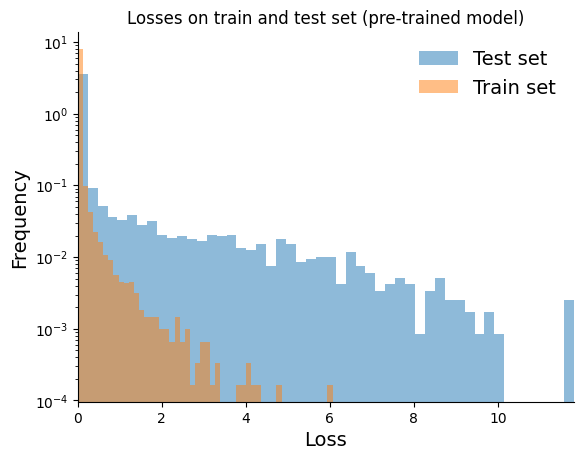

In [ ]:
# plot losses on train and test set
plt.title("Losses on train and test set (pre-trained model)")
plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

As per the above plot, the distributions of losses are quite different between the train and test sets, as expected. In what follows, we will define an MIA that leverages the fact that examples that were trained on have smaller losses compared to examples that weren't. Using this fact, the simple MIA defined below will aim to infer whether the forget set was in fact part of the training set.

This MIA is defined below. It takes as input the per-sample losses of the unlearned model on forget and test examples, and a membership label (0 or 1) indicating which of those two groups each sample comes from. It then returns the cross-validation accuracy of a linear model trained to distinguish between the two classes.

Intuitively, an unlearning algorithm is successful with respect to this simple metric if the attacker isn't able to distinguish the forget set from the test set any better than it would for the ideal unlearning algorithm (retraining from scratch without the retain set); see the last section of this notebook for additional discussion and for computing that reference point.

In [ ]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

As a reference point, we first compute the accuracy of the MIA on the original model to distinguish between the forget set and the test set.

In [ ]:
forget_losses = compute_losses(model, forget_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[: len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.577 on forgotten vs unseen images


We'll now compute the accuracy of the MIA on the unlearned model. We expect the MIA to be less accurate on the unlearned model than on the original model, since the original model has not undergone a procedure to unlearn the forget set.

In [ ]:
# ft_forget_losses = compute_losses(ft_model, forget_loader)
# ft_test_losses = compute_losses(ft_model, test_loader)

# # make sure we have a balanced dataset for the MIA
# assert len(ft_test_losses) == len(ft_forget_losses)

# ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
# labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)



ft2_forget_losses = compute_losses(ft_model2, forget_loader)
ft2_test_losses = compute_losses(ft_model2, test_loader)

# make sure we have a balanced dataset for the MIA
assert len(ft2_test_losses) == len(ft2_forget_losses)

ft2_samples_mia = np.concatenate((ft2_test_losses, ft2_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(ft2_test_losses) + [1] * len(ft2_forget_losses)

In [ ]:
# ft_mia_scores = simple_mia(ft_samples_mia, labels_mia)

# print(
#     f"The MIA has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images"
# )


ft2_mia_scores = simple_mia(ft2_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {ft2_mia_scores.mean():.3f} on forgotten vs unseen images"
)



The MIA has an accuracy of 0.491 on forgotten vs unseen images


From the score above, the MIA is indeed less accurate on the unlearned model than on the original model, as expected. Finally, we'll plot the histogram of losses of the unlearned model on the train and test set. From the below figure, we can observe that the distributions of forget and test losses are more similar under the unlearned model compared to the original model, as expected.

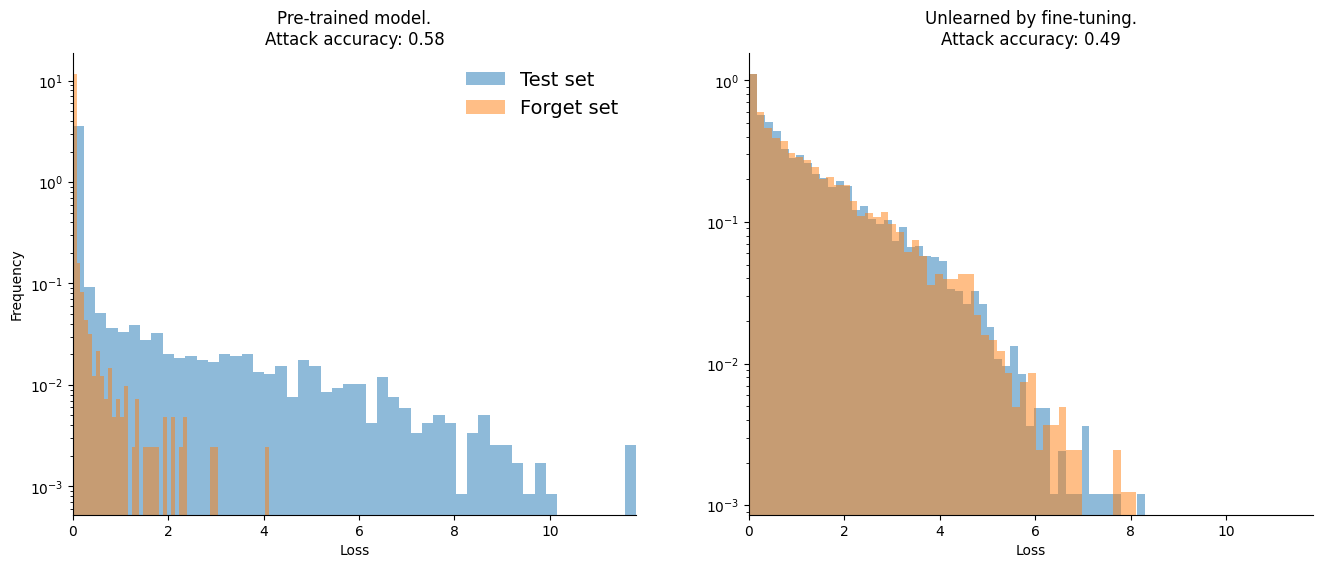

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
# ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
# ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

# ax2.set_title(
#     f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
# )
# ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
# ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

# ax1.set_xlabel("Loss")
# ax2.set_xlabel("Loss")
# ax1.set_ylabel("Frequency")
# ax1.set_yscale("log")
# ax2.set_yscale("log")
# ax1.set_xlim((0, np.max(test_losses)))
# ax2.set_xlim((0, np.max(test_losses)))
# for ax in (ax1, ax2):
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)
# ax1.legend(frameon=False, fontsize=14)
# plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft2_mia_scores.mean():0.2f}"
)
ax2.hist(ft2_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft2_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

## Comparison with a re-trained model

One might ask, how good are the scores above? What is the best score? Since our goal is to approximate the model that has been trained only on the retain set, we'll consider that the gold standard is the score achieved by this model. Intuitively, we expect the MIA accuracy to be around 0.5, since for such a model, both the forget and test set are unseen samples from the same distribution. However, a number of factors such as distribution shift or class imbalance can make this number vary.

We'll now compute this score. We'll first download the weights for a model trained exclusively on the retain set and then compute the accuracy of the simple MIA.

In [ ]:
# download weights of a model trained exclusively on the retain set
local_path = "retrain_weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/" + local_path
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
rt_model = resnet18(weights=None, num_classes=10)
rt_model.load_state_dict(weights_pretrained)
rt_model.to(DEVICE)
rt_model.eval()

# print its accuracy on retain and forget set
print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")

Retain set accuracy: 99.5%
Forget set accuracy: 88.2%


As expected, the model trained exclusively on the retain set has a higher accuracy on the retain set than on the forget set (whose accuracy is similar than on the test set)

In [ ]:
rt_test_losses = compute_losses(rt_model, test_loader)
rt_forget_losses = compute_losses(rt_model, forget_loader)

rt_samples_mia = np.concatenate((rt_test_losses, rt_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(rt_test_losses) + [1] * len(rt_forget_losses)

In [ ]:
rt_mia_scores = simple_mia(rt_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {rt_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.499 on forgotten vs unseen images


As we expect, the accuracy of the MIA attack is roughly 0.5. Finally, as we've done before, let's compare the histograms of this ideal algorithm (re-trained model) vs the model obtain from

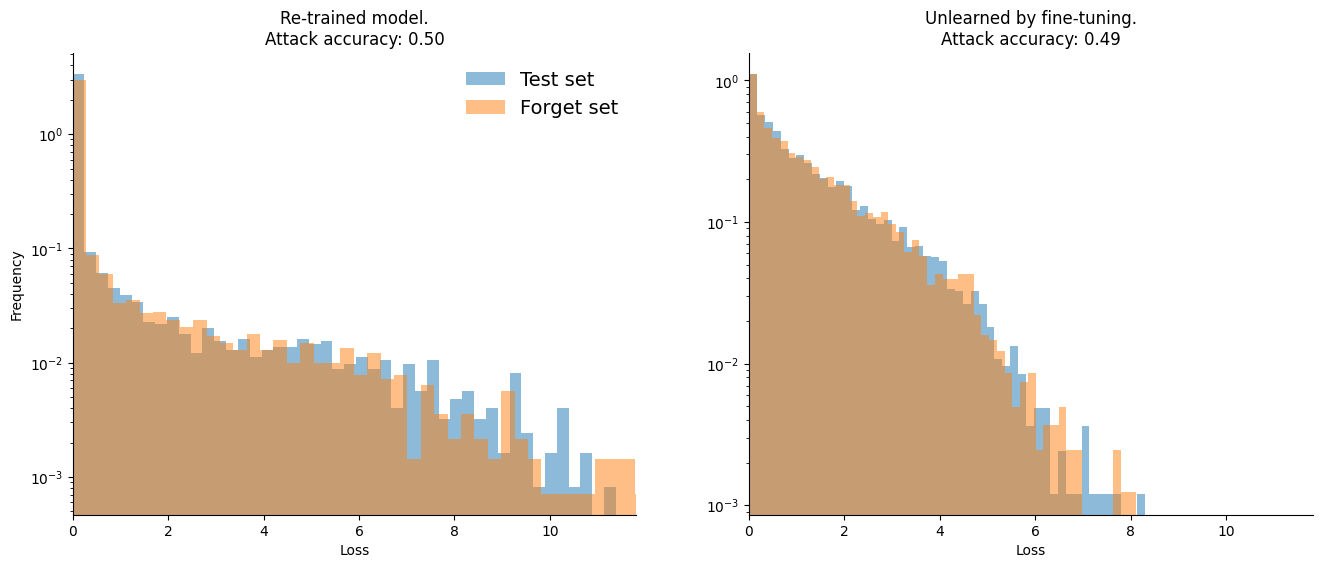

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ax1.set_title(f"Re-trained model.\nAttack accuracy: {rt_mia_scores.mean():0.2f}")
# ax1.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
# ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

# ax2.set_title(
#     f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
# )
# ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
# ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

# ax1.set_xlabel("Loss")
# ax2.set_xlabel("Loss")
# ax1.set_ylabel("Frequency")
# ax1.set_yscale("log")
# ax2.set_yscale("log")
# ax1.set_xlim((0, np.max(test_losses)))
# ax2.set_xlim((0, np.max(test_losses)))
# for ax in (ax1, ax2):
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)
# ax1.legend(frameon=False, fontsize=14)
# plt.show()



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Re-trained model.\nAttack accuracy: {rt_mia_scores.mean():0.2f}")
ax1.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft2_mia_scores.mean():0.2f}"
)
ax2.hist(ft2_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft2_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()